# Codificação energética eficiente para rede de sensores sem fio

_Fernando Matheus do Nascimento Dantas_

## Objetivo

* Apresentar uma comparação qualitativa entre consumos dos esquema de BPSK e com codificação Wavelet

* O contexto é comunicação entre sensores Wireless


In [1]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib notebook

## Transmissão BPSK

A seguir, estão definidas as funções utilizadas, respectivamente, para a pseudo-fonte, modulação e demodulação do esquema BPSK.

In [14]:
SYMBOLS = [-1, 1]

def bpsk_modulate(N):
    return np.random.choice(SYMBOLS, int(N))

def bpsk_demodulate(transmitted):
    demodulated = np.ones(transmitted.shape) * -1
    demodulated[transmitted >= 0] = 1
    return demodulated

### Transmissão BPSK

A probabilidade de erro calculada para o esquema BPSK é

$$P_e = \dfrac{1}{2}\text{erfc}\left(\sqrt{\frac{E_b}{N_0}}\right)$$

In [141]:
N = 100000
EbNo = np.arange(0, 10, 1)
EbNo_linear = 10 ** (EbNo / 10)
No = 1 / EbNo_linear
sigma = np.sqrt(No / 2)
pe_bpsk_theoretical = 0.5 * erfc(np.sqrt(EbNo_linear))

modulated = bpsk_modulate(N)

pe_bpsk = np.zeros(len(EbNo))
for i in range(len(EbNo)):
    noise = np.random.normal(0, sigma[i], N)
    transmitted = modulated + noise
    demodulated = bpsk_demodulate(transmitted)
    pe_bpsk[i] = np.average(modulated != demodulated)

### Validação da transmissão BPSK

A média da diferença entre a curva teórica e a simulada é apresentada, como maneira de mensurar a qualidade da simulação. 

Note que o valor resultante é praticamente desprezível.

In [152]:
error = np.average(pe_bpsk_theoretical - pe_bpsk)

print(f'O erro médio é {error:.2g}')

O erro médio é 5.9e-05


## Transmissão com Codificação Wavelet

A seguinte classe é proposta para lidar com a codificação Wavelet:

In [20]:
class Wavelet:
    def __init__(self, m, g):
        self.m = m
        self.g = g
        self.mg = m * g
        self.A = None
        self.mcw = None

    def _allocate_a_matrix(self):
        if self.A is None:
            self.A = np.zeros((self.m, self.mg))

    def _get_raw_lines(self, file, type=float):
        with open(file, 'r') as file:
            flatten = [type(l) for l in file.readlines()]
            size = int(np.size(flatten))
            step = int(size / self.m)
            for i in np.arange(0, size, step):
                yield flatten[i: i + step]

    def _set_a_coefficients(self, file):
        self._allocate_a_matrix()
        lines = self._get_raw_lines(file)
        for i in range(self.m):
            self.A[i] = next(lines)

    def _allocate_mcw(self, message_length):
        if self.mcw is None:
            self.mcw = np.zeros((self.m, message_length + self.mg - self.m))

    def _displace_mcw(self, pad):
        self.mcw = np.roll(self.mcw, pad)

    def _get_encoded_model(self):
        return np.zeros((self.mcw.shape[1],))

    def mcw_from_coefficients(self, file, message_length):
        self._set_a_coefficients(file)
        self._allocate_mcw(message_length)
        self.mcw[:self.m, :self.mg] = self.A

    def encode(self, message):
        encoded = self._get_encoded_model()
        mcw = np.copy(self.mcw)
        for i in range(0, np.size(message), self.m):
            encoded += np.matmul(message[i: i + self.m], mcw)
            mcw = np.roll(mcw, self.m)
        return encoded

    def _get_decoded_model(self):
        return np.zeros((self.mcw.shape[1] - self.mg + self.m,))

    def decode(self, encoded):
        decoded = self._get_decoded_model()
        mcw = np.copy(self.mcw)
        for i in range(np.size(decoded)):
            if i and i % self.m == 0:
                mcw = np.roll(mcw, self.m)
            decoded[i] = np.dot(mcw[i % self.m], encoded)
        return decoded

### Validação (prática) da codificação Wavelet

A validação mostrada aqui é relativamente mais pragmática que a do esquema BPSK, que considera a curva teórica. Será considerada a codificação e decodificação de uma palavra de 10000 símbolos (-1 ou +1), na ausência de ruído. Constatar-se-á que o resultado da decodificação será exatamente igual ao da mensagem transmitida, o que, para efeitos práticos, denota que a codificação e decodificação funcionam corretamente.

In [21]:
message = np.random.choice([-1, 1], 10000)
N = np.size(message)

O objeto `Wavelet(m=2, g=64)` simboliza um codificador/decodificador wavelet com posto 2 e gênero 64.

In [22]:
wavelet = Wavelet(m=2, g=64)

A Matriz de Codificação Wavelet utilizada é carregada em `wavelet` por meio do método `wavelet.mcw_from_coefficients(file)`, em que `file` é um arquivo de texto que contém os coeficientes da MCW. O sentido de leitura do `.txt` é tal que as linhas da MCW são preenchidas uma a uma, da esquerda para direita, até que não haja mais elementos a serem lidos.

In [23]:
file = '../mcw2_128.txt'
wavelet.mcw_from_coefficients(file, N)

Pode-se realizar, agora, a codificação e decodificação através dos métodos `encode` e `decode`.

In [24]:
encoded = wavelet.encode(message)
decoded = wavelet.decode(encoded)

Verifica-se que a magnitude de todos os símbolos decodificados é $mg$. `set`, aqui, remove todos os elementos repetidos de `decoded`; `{wavelet.mg}` é um `set` com cardinalidade 1 (um), cujo único elemento é `wavelet.mg = 128`.

In [25]:
set(np.abs(decoded)) == {wavelet.mg}

True

Limita-se os valores de `decoded` aos símbolos originais transmitidos ($-mg \Rightarrow -1, +mg \Rightarrow +1$).

In [26]:
decoded[decoded == wavelet.mg] = 1
decoded[decoded == -wavelet.mg] = -1

Finalmente, verifica-se que `decoded` é **igual** a `message` (naturalmente, pois não houve interferência de qualquer ruído durante o processo).

In [27]:
np.array_equal(decoded, message)

True

### Transmissão com codificação wavelet

A informação a ser transmitida será a mesma da codificação BPSK, contida em `modulated`, já definida na seção de simulação BPSK.

Os símbolos $y_n$ serão modulados por uma constelação ASK, com $mg+1$ pontos. 

O canal está sujeito, assim como no caso BPSK, a um ruído aditivo gaussiano de média nula e densidade espectral de potência igual a $N_0/2$, de tal maneira que os símbolos recebidos no decodificador serão $\text{Re}\{y_n + \mathbf{n}_n\}$, em que $\mathbf{n}_n$ é um número complexo composto por variáveis aleatórias Gaussianas independentes e identicamente distribuídas com média nula e variância $N_0/2$.

A densidade espectral de potência do ruído é $N_0=mg\cdot 10^{-0.1\left(\frac{E_b}{N_0}\right) \text{ dB}}$

In [128]:
EbNo = np.arange(0, 10, 1)
No = wavelet.mg * 10 ** (-EbNo / 10)
sigma = np.sqrt(No / 2)

In [108]:
wavelet = Wavelet(m=2, g=64)
wavelet.mcw_from_coefficients('../mcw2_128.txt', np.size(modulated))

In [111]:
encoded = wavelet.encode(modulated)

`alphabet` são os possíveis símbolos de $y_n$.

In [160]:
alphabet = np.array([-wavelet.mg + 2 * k for k in range(wavelet.mg + 1)])

print(f'Cardinalidade de alphabet = mg + 1 = {len(alphabet)}')

Cardinalidade de alphabet = mg + 1 = 129


`ask_demodulate` demodula os símbolos que chegam ao decodificador utilizando os símbolos definidos por `alphabet`.

In [93]:
def ask_demodulate(transmitted):
    indices = np.abs(np.subtract.outer(alphabet, transmitted)).argmin(0)
    return np.asarray([alphabet[i] for i in indices])

**Loop principal.** Estimação da probabilidade de erro _vs._ $Eb/N_0$.

In [112]:
pe_wavelet = np.zeros(len(EbNo))

for i in range(len(EbNo)):
    transmitted = np.random.normal(encoded, sigma[i], np.size(encoded))
    demodulated = ask_demodulate(transmitted)
    decoded = wavelet.decode(demodulated) / wavelet.mg
    pe_wavelet[i] = np.average(np.sign(decoded) != modulated)
    print(f"Iteração {i}/{len(EbNo) - 1}")
    print(f"\tpe_wavelet = {pe_wavelet[i]}")

Iteração 0/9
	pe = 0.08021
Iteração 1/9
	pe = 0.0574
Iteração 2/9
	pe = 0.03876
Iteração 3/9
	pe = 0.02469
Iteração 4/9
	pe = 0.01358
Iteração 5/9
	pe = 0.00644
Iteração 6/9
	pe = 0.00266
Iteração 7/9
	pe = 0.00092
Iteração 8/9
	pe = 0.00027
Iteração 9/9
	pe = 4e-05


## Resultados

### Curvas $BER \times E_b/N_0$

<IPython.core.display.Javascript object>


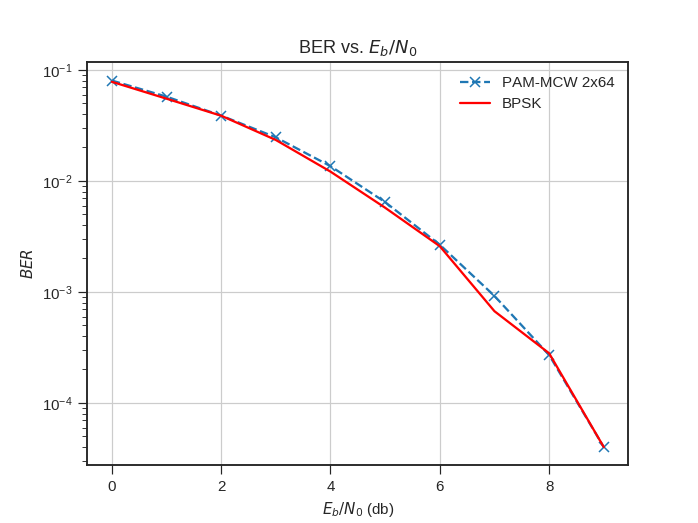

In [147]:
plt.title("BER vs. $E_b/N_0$")
plt.plot(EbNo, pe_wavelet, 'x--', label="PAM-MCW 2x64")
plt.plot(EbNo, pe_bpsk, 'r', label="BPSK")
plt.legend()
plt.yscale("log")
plt.xlabel("$E_b/N_0$ (db)")
plt.ylabel("$BER$")
plt.grid(True)

### Curvas de gasto energético

Para fins de simulação e comparação, a potência transmitida pelo sensor, denotada pela variável ```Pt```, foi fixada em 1 mW.

O modelo utilizado foi

$$E_b = \frac{P T_{DATA}}{N_{MAC} * (1-p_e)}\text{ [J/bit]}$$ 

Os parâmetros do sensor foram retirados do artigo utilizado como referência para o modelo energético, os quais estão indicados abaixo com suas respectivas dimensões.

In [144]:
Tdata = 1  # sec
tst = 195e-6  # sec
Lsync = 24 * 8 / 1000  # kbits
Lrts = 30 * 8 / 1000  # kbits
Ldata = 82 * 8 / 1000  # kbits
Lcts = 24 * 8 / 1000  # kbits
Rr = 20  # kbps

ttx = (1 / Tdata) * (3 * tst + Lsync / Rr + Lrts / Rr + Ldata / Rr)
trx = (1 / Tdata) * (tst + Lcts / Rr)

Pto = 15.9e-3  # W
alpha = 3.2  # adimensional
Pt = 1e-3  # W

Ptx = Pto + (alpha + 1) * Pt  # W
Prx = 22.2e-3  # W
Psleep = 37e-6  # W

P = ttx * Ptx + trx * Prx + (1 - ttx - trx) * Psleep  # W

Nphy = 72  # byte
Omac = 10  # byte
Nmac = (Nphy - Omac) * 8  # bits

Eb_wavelet = P * Tdata / (Nmac * (1 - pe_wavelet))
Eb_bpsk = P * Tdata / (Nmac * (1 - pe_bpsk))

<IPython.core.display.Javascript object>


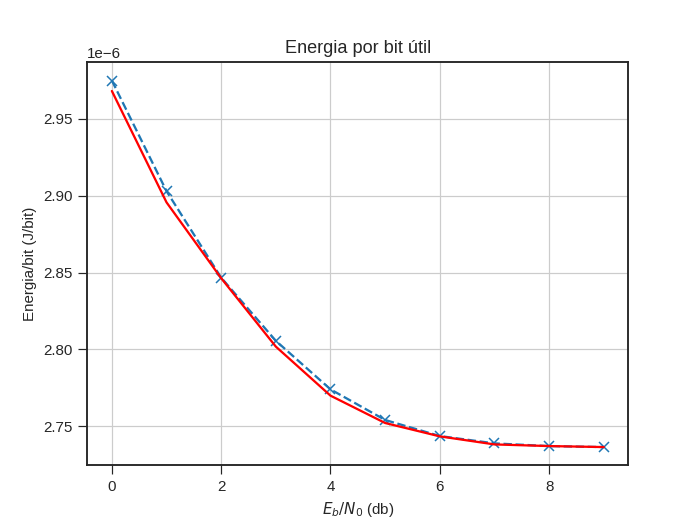

In [161]:
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.title("Energia por bit útil")
plt.ylabel("Energia/bit (J/bit)")
plt.xlabel("$E_b/N_0$ (db)")
plt.plot(EbNo, Eb_wavelet, 'x--', label="PAM-MCW 2x64")
plt.plot(EbNo, Eb_bpsk, 'r', label="BPSK")
plt.legend()
plt.grid(True)
plt.show()

## Conclusão

As curvas plotadas mostram que, para o esquema BPSK, o desempenho da codificação Wavelet não alterou significativamente a eficiência da transmissão. As probabilidades de erro para os dois esquemas mostraram-se muito próximas e, consequentemente, os consumos energéticos.